In [1]:
import os, sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

# from models import ResNet as resnet_cifar

from model_analysis import ResNet as resnet_cifar
import pandas as pd
import argparse
import csv
from torch.optim.lr_scheduler import MultiStepLR
from dataLoader import DataLoader
from summaries import TensorboardSummary

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc,precision_recall_curve
import sklearn

from sklearn.metrics import confusion_matrix, classification_report    # 生成混淆矩阵函数
# from sklearn import cross_validation

print('Initialization')
print('Init Finished!')

Initialization
Init Finished!


In [2]:
# Data Loader
args_dataset = 'cifar-10'
args_batch_size = 1024
loader = DataLoader(args_dataset,batch_size=args_batch_size)
dataloaders,dataset_sizes = loader.load_data()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
def load_model(mask_value,path):
    model = resnet_cifar(depth=args_depth, num_classes=num_classes,mask_value=mask_value)
    model = model.cuda()
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(path))
    # model = torch.load(model_path)
    print('Successfully Load Model: ', os.path.basename(path))
    return model

In [4]:
def printF(i, total=100):
    i = int( i / total * 100) + 1
    total = 100
    k = i + 1
    str_ = '>'*i + '' ''*(total-k)
    sys.stdout.write('\r'+str_+'[%s%%]'%(i+1))
    sys.stdout.flush()
    if(i >= total -1): print()

In [5]:
labels_name = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(sklearn.__version__)
def predict(model):
    use_gpu = True
    epoch = 1
    phase = 'val'
    running_corrects = 0.0
    data_len = len(dataloaders[phase])
    # print(data_len)
    true_labels = []
    mul_labels = []
    model_preds = []
    y_scores = []
    plane_number = 0
    true_positive = 0
    predict_plane = 0
    for idx,data in enumerate(dataloaders[phase]):
        printF(idx, data_len)
        inputs,labels = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #forward
        outputs = model(inputs, labels, epoch)
        _, preds = torch.max(outputs.data, 1)

        y = labels.data
        batch_size = labels.data.shape[0]
        plane_scores = outputs[:,0]

        running_corrects += torch.sum(preds == y)
        plane_number += torch.sum(y==0)
        true_positive += torch.sum(((preds==0)+(y==0))==2)
#         print(torch.sum(y==0))
#         print(true_positive)
        predict_plane += torch.sum(preds==0)

        true_labels.extend(y.cpu().numpy()==0)
        mul_labels.extend(y.cpu().numpy())
        model_preds.extend(preds.cpu().numpy())
        y_scores.extend(plane_scores.cpu().detach().numpy())

    epoch_acc = float(running_corrects) /dataset_sizes[phase]
#     print(dataset_sizes[phase])
    print('%s top1 Acc:%.4f'%(phase,epoch_acc))
#     print(true_positive)
    if float(predict_plane) == 0:
        plane_acc = 0.0
        plane_recall = 0.0
    else:
        plane_acc = float(true_positive.data) / float(predict_plane)
        plane_recall = float(true_positive.data) /  float(plane_number)
    
#     print(plane_acc)
    
#     classification_report = classification_report(mul_labels,model_preds,target_names=labels_name)
    return true_labels,y_scores,plane_acc,plane_recall

0.18.1


In [6]:
args_depth = 20
num_classes = 10

PATH_Mask0 = '../tb_dir/cifar_exp/test_256bs_150epoch_layer3_mask0_train_test'
PATH_Mask1 = '../tb_dir/cifar_exp/test_256bs_150epoch_layer3_open'
PATH = '../tb_dir/cifar_exp/baseline'
# PATH = '../tb_dir/debug/icnn_4'
baseline_model_path = os.path.join(PATH, 'saved_model.pt')
model_path = os.path.join(PATH_Mask0, 'saved_model.pt')
mask1_path = os.path.join(PATH_Mask1, 'saved_model.pt')

plt.figure()
lw = 2
plt.figure(figsize=(6,6))  
    

In [7]:
print('-'*10,'icnn model','-'*10)
mask_value = 0
num = 20
step = 1.0/20
precisions = []
recalls = []
for i in range(20):
    model = load_model(mask_value,model_path)
    mask0_true_labels,mask0_y_scores,acc,recall= predict(model)
    print(acc,recall)
#     acc,recall,threshold = precision_recall_curve(true_labels,y_scores)
    precisions.append(acc)
    recalls.append(recall)
    mask_value += step



---------- icnn model ----------
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.7447
0.33122923588039865 0.997
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.7661
0.3616557734204793 0.996
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.7849
0.3949145808502185 0.994
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.8026
0.4304291287386216 0.993
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.8163
0.46326626111371083 0.99
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>

In [8]:
# assert False
print('-'*10,'baseline model','-'*10)
precisions_baseline = []
recalls_baseline = []
mask_value = 0
for i in range(20):
    model = load_model(mask_value,baseline_model_path)
    base_true_labels,base_y_scores,acc,recall = predict(model)
    print(acc,recall)
#     acc,recall,threshold = precision_recall_curve(true_labels,y_scores)
    precisions_baseline.append(acc)
    recalls_baseline.append(recall)
    mask_value += step


---------- baseline model ----------
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.8793
0.888 0.888
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.8792
0.8896690070210632 0.887
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.8792
0.8905622489959839 0.887
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.8798
0.8904522613065327 0.886
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.8803
0.8904522613065327 0.886
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>

In [9]:
print('-'*10,'icnn mask1 model','-'*10)
precisions_mask1 = []
recalls_mask1 = []
mask_value = 0
for i in range(20):
    model = load_model(mask_value,mask1_path)
    mask1_true_labels,mask1_y_scores,acc,recall = predict(model)
    print(acc,recall)
#     acc,recall,threshold = precision_recall_curve(true_labels,y_scores)
    precisions_mask1.append(acc)
    recalls_mask1.append(recall)
    mask_value += step


---------- icnn mask1 model ----------
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.8073
0.0 0.0
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.8074
0.0 0.0
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.8071
0.0 0.0
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.8070
1.0 0.001
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[92%]val top1 Acc:0.8092
1.0 0.022
Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

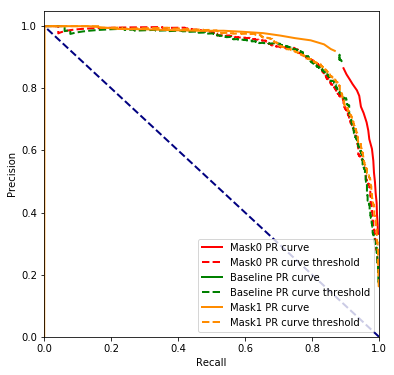

In [10]:

# plt.plot(recalls_baseline,precisions_baseline, color='darkorange',
#          lw=lw, label='Baseline PR mask curve') ###假正率为横坐标，真正率为纵坐标做曲线
# plt.plot(recall,acc,color='green',
#          lw=lw, label='Baseline PR curve') ###假正率为横坐标，真正率为纵坐标做曲线
# plt.plot(recall,acc,color='blue',
#          lw=lw, label='Mask1 PR curve') ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot(recalls,precisions,color='red',
         lw=lw, label='Mask0 PR curve') ###假正率为横坐标，真正率为纵坐标做曲线
acc,recall,threshold = precision_recall_curve(mask0_true_labels,mask0_y_scores)
plt.plot(recall,acc,color='red',
         lw=lw, label='Mask0 PR curve threshold', linestyle='--') ###假正率为横坐标，真正率为纵坐标做曲线

plt.plot(recalls_baseline,precisions_baseline,color='green',
         lw=lw, label='Baseline PR curve') ###假正率为横坐标，真正率为纵坐标做曲线
acc,recall,threshold = precision_recall_curve(base_true_labels,base_y_scores)
plt.plot(recall,acc,color='green',
         lw=lw, label='Baseline PR curve threshold', linestyle='--')

plt.plot(recalls_mask1,precisions_mask1,color='darkorange',
         lw=lw, label='Mask1 PR curve') ###假正率为横坐标，真正率为纵坐标做曲线
acc,recall,threshold = precision_recall_curve(mask1_true_labels,mask1_y_scores)
plt.plot(recall,acc,color='darkorange',
         lw=lw, label='Mask1 PR curve threshold', linestyle='--')

plt.plot([1, 0], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()